In [25]:
%matplotlib inline
import pygrib
import numpy as np
from netCDF4 import Dataset
import os
from scipy import spatial
import pandas as pd
def lon_convert(station_lon):
    if station_lon<0:
        diff_from_180=180+station_lon
        station_lon_360=180+diff_from_180
        station_lon_180=station_lon
    else:
        diff_from_360=360-station_lon
        station_lon_180=-diff_from_360
        station_lon_360=station_lon
    return(station_lon_180,station_lon_360)

#This came from Stack Overflow! Thanks random internet person
#https://stackoverflow.com/questions/8661537/how-to-perform-bilinear-interpolation-in-python
def bilinear_interpolation(x,y,coord_vals):
    #We are assuming that the coord_vals are a list of 4 tuples containing
    #x,y,and value
    coords=sorted(coord_vals)
    (x1,y1,q11),(_x1,y2,q12),(x2,_y1,q21),(_x2,_y2,q22) = coords
    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')
        
    return (q11 * (x2 - x) * (y2 - y) +
        q21 * (x - x1) * (y2 - y) +
        q12 * (x2 - x) * (y - y1) +
        q22 * (x - x1) * (y - y1)
       ) / ((x2 - x1) * (y2 - y1) + 0.0)


In [39]:

def interpolate_around_station(ystart,yend,var_string,lat_south,
                              lat_north,lon_west,lon_east,
                               station_lat,station_lon):
    #Convert longitude coordinates
    station_lon_180,station_lon_360=lon_convert(station_lon)
    mon_str=["{num:02d}".format(num=m) for m in range(1,13)]

    print('reading in variable '+var_string)
    #Find the points (read in lat/lon data from example grib file)
    fstr='/gpfs/fs1/collections/rda/data/ds627.1/ei.moda.an.sfc/ei.moda.an.sfc.regn128sc.1979010100'
    grib_open=pygrib.open(fstr)
    grib_var=grib_open.select(name=var_string)[0]
    data,lats,lons=grib_var.data(lat1=lat_south,lat2=lat_north,
                                       lon1=lon_west,lon2=lon_east)
    #make the lat and lon axes
    lat_axis=lats[:,0]
    lon_axis=lons[0,:]
        
    pt=[station_lon_360,station_lat]

    #Find the 4 nearest coordinates
    #First in the x direction
    x_dist=[abs(station_lon_360-l) for l in lon_axis]
    #Then the y
    y_dist=[abs(station_lat-l) for l in lat_axis]

    idx=np.argpartition(x_dist,2)
    idy=np.argpartition(y_dist,2)

    nearest_inds=[]
    nearest_pts=[]

    #make tuples of the coordinate pairs
    for i in range(0,2):
        for j in range(0,2):
            nearest_inds.append((idx[i],idy[j]))
            nearest_pts.append((lon_axis[idx[i]],lat_axis[idy[j]]))
            
    interp_vals=[]
    dates=[]
    mon_sum=np.zeros(12,dtype=float)
    for y in range(ystart,(yend+1)):
        mstart=0
        mend=12
        if y==ystart:
            mstart=mon_str.index('10')
        elif y==(yend):
            mend=mon_str.index('09')+1

        for m in range(mstart,mend):
            fstr='/gpfs/fs1/collections/rda/data/ds627.1/ei.moda.an.sfc/ei.moda.an.sfc.regn128sc.'+str(y)+mon_str[m]+'0100'
            #print('opening '+ fstr)
            #Open the grib file
            strdate=str(y)+'-'+mon_str[m]
            dates.append(strdate)
            #print(strdate)
            grib_open=pygrib.open(fstr)
            grib_var=grib_open.select(name=var_string)[0]
            #subset the variable
            var,lats,lons=grib_var.data(lat1=lat_south,lat2=lat_north,
                                       lon1=lon_west,lon2=lon_east)

            #grab the value that corresponds to the lat/lon pairs
            nearest_copy=nearest_pts.copy()
            for i in range(0,len(nearest_inds)):
                val=var[nearest_inds[i]]
                nearest_copy[i]=nearest_copy[i]+(val,)

            new_val=bilinear_interpolation(station_lon_360,
                                           station_lat,nearest_copy)
            mon_sum[m]+=new_val
            interp_vals.append(new_val)
            #close the grib file
            grib_open.close()
    ny=yend-ystart
    mon_avg=mon_sum/ny
    
    interp_copy=interp_vals.copy()
    anom_vals=[]
    for i in range(0,len(interp_copy)):
        date_month=dates[i][5:]
        mon_ind=int(date_month)-1
        anom_vals.append(interp_copy[i]-mon_avg[mon_ind])
    
    return(interp_vals,anom_vals,dates)



In [66]:
ystart=1979
yend=2017
var_string='2 metre temperature'
lat_south=32
lat_north=52
lon_west=234
lon_east=260
station_lat=38.5050
station_lon=-107.8975

temps,anoms,dates=interpolate_around_station(ystart,yend,var_string,lat_south,lat_north,lon_west,lon_east,station_lat,station_lon)


reading in variable 2 metre temperature


In [67]:
index = pd.date_range(start='10-01-'+str(ystart), end='09-30-'+str(yend), freq='M')

In [68]:
df = pd.DataFrame(data=anoms, index=index,columns=['anoms'])

mtemp=np.mean(temps)
stemp=np.std(temps)
temp_norm=(temps-mtemp)/stemp
df['temps_norm']=temp_norm

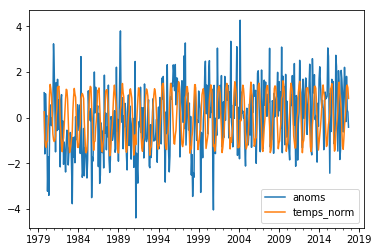

In [69]:
df.plot()

38

38